# Average Annual Daily Traffic (Current)

Minnesota Department of Transport (MnDoT)

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/trans-aadt-traffic-segments

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/metadata/metadata.html

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# import psycopg2
# from psycopg2 import sql, extras

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd

# Get CWD

cwd = os.getcwd() # This is a global variable for where the notebook is (must change if running in arcpro)

In [3]:
# Load Traffic segments

datapath = os.path.join('..', '..', 'Data')

aadt_for_db = gpd.read_file(os.path.join(datapath, 'MNDOT_AADT.geojson'))

In [4]:
# Get the list of important street names

# Narrow by streets with names that have high volume

# Remove Nans in aadt_for_db

no_nan_df = aadt_for_db.dropna()

# Dissolve by route_label

grouped_df = no_nan_df.dissolve(by='ROUTE_LABEL', aggfunc={'STREET_NAME':'unique',
                                                            'CURRENT_VOLUME':'mean'}).reset_index()
# Select high volume intersections with names
select_df = grouped_df[(grouped_df.CURRENT_VOLUME > 1000)]

important_street_names = select_df.STREET_NAME.explode().unique()

In [5]:
# Select the streets from above and that have linestrings (not multilinestrings) in their geometry

focus_df = aadt_for_db[(aadt_for_db.STREET_NAME.isin(important_street_names))&
                        (aadt_for_db.geometry.type != 'MultiLineString')].copy() 

In [6]:
# Get the line trend (EastWest or NorthSouth) of each

def get_linetrend(geom):
    '''This looks at the first and last points in a UTM geometry linestring 
    and says if it trends more North South (NS) or East West (EW)
    '''
    
    coords = list(geom.coords)

    first_coord = coords[0]
    last_coord = coords[-1]

    ns_trend = abs(first_coord[1] - last_coord[1])

    ew_trend = abs(first_coord[0] - last_coord[0])

    if ns_trend > ew_trend:
        result = 'NS'
    else:
        result = 'EW'

    return result

focus_df['linetrend'] = focus_df.geometry.apply(lambda x: get_linetrend(x))

In [7]:
# Get all intersections of roads

# Cross join - https://gis.stackexchange.com/questions/439723/implementing-polygon-self-intersection-in-python

focus_df['id'] = np.arange(focus_df.shape[0]) #Create an id column

cross = pd.merge(left=focus_df, right=focus_df, how='cross') #Cross join the dataframe to itself

cross = cross.loc[cross['id_x'] < cross['id_y']] #Remove self joins

cross = cross.loc[cross.geometry_x.intersects(cross.geometry_y)] #Select only polygons intersecting

cross['inter'] = cross.geometry_x.intersection(cross.geometry_y) #Intersect them

cross = cross.set_geometry('inter') #The error was here. I thought set_geometry was inplace, but it is returning the dataframe

cross = cross[[column for column in cross.columns if 'geom' not in column]] #Drop old geometries

In [8]:
# Now to find the NS and EW cross streets

cross['NS_cross_street'] = None
cross['EW_cross_street'] = None

for i, row in cross.iterrows():

    # Get NS cross street

    if row.linetrend_x == 'NS':
        cross.loc[i, 'NS_cross_street'] = row.STREET_NAME_x
    elif row.linetrend_y == 'NS': 
        cross.loc[i, 'NS_cross_street'] = row.STREET_NAME_y

    # Get EW cross street

    if row.linetrend_x == 'EW':
        cross.loc[i, 'EW_cross_street'] = row.STREET_NAME_x
    elif row.linetrend_y == 'EW': 
        cross.loc[i, 'EW_cross_street'] = row.STREET_NAME_y

# The final dataframe?

intersections_df = cross[['NS_cross_street', 'EW_cross_street', 'inter']].dropna().copy().reset_index(drop=True)

intersections_df

,NS_cross_street,EW_cross_street,inter
0,Nicollet Ave S,W 61st St,POINT (478042.278 4971026.506)
1,Lyndale Ave S,W 61st St,POINT (477234.219 4971031.999)
2,Lyndale Ave S,W 61st St,POINT (477234.219 4971031.999)
3,Nicollet Ave S,W 61st St,POINT (478042.278 4971026.506)
4,Portland Ave S,E 60th St,POINT (478860.281 4971245.500)
...,...,...,...
1307,46th Ave S,E 38th St,POINT (483613.351 4975675.471)
1308,46th Ave S,E 38th St,POINT (483613.351 4975675.471)
1309,W River Pkwy,E 38th St,POINT (483980.374 4975676.203)
1310,46th Ave S,E Lake St,POINT (483620.876 4977236.500)


<Axes: >

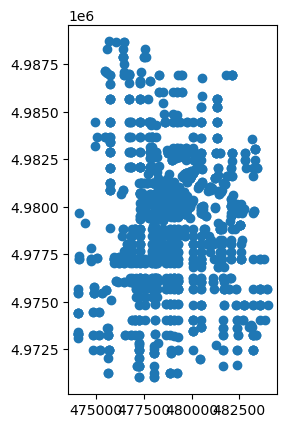

In [9]:
# Looks like good coverage

intersections_df.plot()

In [11]:
# Let's Save that

intersections_df.to_file(os.path.join(datapath, 'Road_Intersections.geojson'))

In [48]:
# Upload to Database (NOT DONE, CHANGE THIS!)

# Get credentials

cred_pth = os.path.join(os.getcwd(), '..', '..', 'database', 'db_credentials.txt')

with open(cred_pth, 'r') as f:
    
    creds = f.readlines()[0].rstrip('\n').split(', ')
    
# Connect to PostGIS Database

pg_connection_dict = dict(zip(['dbname', 'user', 'password', 'port', 'host'], creds))

conn = psycopg2.connect(**pg_connection_dict)

# Create Cursor for commands

cur = conn.cursor()

# Insert into table

cols_for_arc = ['SEQUENCE_N','ROUTE_LABE','STREET_NAM',
                'DAILY_FACT', 'SEASONAL_F', 'AXLE_FACTO',
                'CURRENT_YE','CURRENT_VO', 'SHAPE@WKT']

cols_for_dataframe = ['SEQUENCE_NUMBER','ROUTE_LABEL','STREET_NAME',
                      'DAILY_FACTOR', 'SEASONAL_FACTOR', 'AXLE_FACTOR',
                      'CURRENT_YEAR','CURRENT_VOLUME', 'geometry']

cols_for_dataframe = [col.lower() for col in cols_for_dataframe] # Must lowercase our columns...


cursor = arcpy.da.SearchCursor(clipped_aadt, cols_for_arc)

for row in cursor:
    
    # This is really a great way to insert a lot of data
    
    q1 = sql.SQL('INSERT INTO MNDOT_Current_AADT_Segments ({}) VALUES ({},{});').format(
     sql.SQL(', ').join(map(sql.Identifier, cols_for_dataframe)),
     sql.SQL(', ').join(sql.Placeholder() * (len(cols_for_dataframe)-1)),
     sql.SQL('ST_Transform(ST_SetSRID(ST_GeomFromText(%s), 26915),4326)::geometry'))
#     print(q1.as_string(conn))
#     break

    cur.execute(q1.as_string(conn),
        (row)
        )
    # Commit command

    conn.commit()

# Close cursor

cur.close()

# Close connection

conn.close()